## Advanced Lane Finding

Brian Erickson

### Abstract
This project aims to find the position of a car in the lane along with the curvature of the road by using advanced lane line finding tecniques.  This is an extension of the earlier lane finding project.  My work for that project is at https://github.com/berickson/CarND-LaneLines-P1 and you can view the notebook at http://nbviewer.jupyter.org/github/berickson/CarND-LaneLines-P1/blob/master/P1.ipynb.  This is all imlemented as part of the Udacity Self Driving Car Nanodegree.


rubric for this project is at https://review.udacity.com/#!/rubrics/571/view

#### Imports and Helper Functions

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython import display
import glob
import pickle
import ipywidgets
%matplotlib inline

In [2]:
def display_images(image_paths, columns=1,width=800,title=None,headings=None):
    column = 0
    html = ''
    if title is not None:
        html = "<b>{0}</b>".format(title)
    html += "<table><tr>"
    if headings is not None:
        for heading in headings:
            html+="<td><b>{0}</b></td>".format(heading)
        html += "</tr><tr>"
    for image_path in image_paths:
        column += 1
        if column > columns:
            column = 1
            html += "</tr><tr>"
        html += "<td>"
        html += "<img width={size} height={size} src='{0}?{r}'>".format(image_path,size=width//columns,r=np.random.randint(1000000))
        html += "<a href={0} target='_blank'>{0}</a>".format(image_path)
        html += "</td>"
    
    html += "</tr></table>"
    display.display(display.HTML(html))

def display_images_side_by_side(left_images,right_images,width=800,title=None,headings=None):
    lr_images = []
    for left_image,right_image in zip(left_images,right_images):
        lr_images.append(left_image)
        lr_images.append(right_image)
    display_images(lr_images, columns=2, width=width, title=title, headings=headings)

In [3]:
def figure_big():
    '''creates a big figure to fill the notebook'''
    fig = plt.figure()
    fig.set_size_inches(w=15,h=10)
    return fig

In [4]:
def get_filename(path):
    '''
    returns the filename part of path, without extension
    
    example:
        get_filename('/abc/myfile.ab') returns 'myfile'
    '''
    return os.path.basename(path).split(".")[0]

#### Goal: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [5]:
calibration_images = glob.glob('camera_cal/calibration*.jpg')
input_videos = ["project_video.mp4", "challenge_video.mp4", "harder_challenge_video.mp4"]
test_images = glob.glob('test_images/*.jpg')

# colors
red = (255,0,0)
green = (0,255,0)
blue = (0,0,255)
cyan = (0,255,255)
white = (255,255,255)

image_width = 1280
image_height = 720

In [6]:
class Camera:
    def __init__(self):
        self.calibrated = False
        
    def calibrate(self, show_annoted = False, show_corrected = False):
        w=9
        h=6
        pattern_size = (w,h)

        # termination criteria
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        single_object_points = np.zeros((w*h,3), np.float32)
        single_object_points[:,:2] = np.mgrid[0:w,0:h].T.reshape(-1,2)

        all_object_points = []
        all_image_points = []
        im_shape = None

        for image_path in calibration_images:
            im = plt.imread(image_path)
            im_gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
            if im_shape == None:
                im_shape = im_gray.shape[::-1]
            found,corners = cv2.findChessboardCorners(im,(9,6),None)
            if found==False: 
                continue
            corners2 = cv2.cornerSubPix(im_gray,corners,(11,11),(-1,-1),criteria)
            all_image_points.append(corners2)
            all_object_points.append(single_object_points)
            if show_annoted:
                plt.figure()
                im_annoted = cv2.drawChessboardCorners(im, pattern_size, corners2, found)
                plt.imshow(im_annoted)

        ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(all_object_points, all_image_points, im_shape,None,None)
        self.dist_coeffs = dist_coeffs
        self.camera_matrix = camera_matrix
        self.calibrated = True
        if show_corrected:
            for image_path in calibration_images:
                im = plt.imread(image_path)   
                plt.figure()
                plt.imshow(cv2.undistort(im,mtx,dst))
    
    def save_calibration(self, path=None):
        if path == None:
            path = 'camera_cal.pickle'
        cal = {}
        cal['dist_coeffs'] = self.dist_coeffs
        cal['camera_matrix'] = self.camera_matrix
        with open( path, "wb" )  as f:
            pickle.dump(cal,f)

    def load_calibration(self, path=None):
        if path == None:
            path = 'camera_cal.pickle'
        cal = {}
        with open( path, "rb" )  as f:
            cal = pickle.load(f)
            self.dist_coeffs = cal['dist_coeffs']
            self.camera_matrix = cal['camera_matrix']
            return True
        return False
        
            
    
    def undistort(self, im):
        if not self.calibrated:
            self.calibrate()
        return cv2.undistort(im,self.camera_matrix,self.dist_coeffs)


In [7]:
def process_images(input_images, process_function, prefix, output_folder = 'output_images', overwrite=True, plot=False):
    output_paths = []
    for input_path in input_images:
        output_path = output_folder+"/"+prefix+os.path.basename(input_path)
        output_paths.append(output_path)
        if overwrite or not os.path.exists(output_path):
            im=plt.imread(input_path)
            im_processed = process_function(im)
            plt.imsave(output_path,im_processed)
        
        if plot:
            fig = plt.figure()
            fig.set_size_inches(w=10,h=5)
            plt.subplot(1,2,1)
            plt.title(input_path)
            plt.imshow(im)
            plt.subplot(1,2,2)
            plt.title(output_path)
            plt.imshow(im_processed,cmap='gray')
    return output_paths

In [8]:
camera = Camera()

In [9]:
if not camera.load_calibration():
    camera.calibrate()
    camera.save_calibration()

#### Goal: Apply a distortion correction to raw images

In [10]:
undistorted_cal_images = process_images(calibration_images, camera.undistort, prefix="undistored",plot = False)

In [11]:
display_images_side_by_side(calibration_images,undistorted_cal_images,headings=['original','undistorted'],title="camera calibration")

original,undistorted
camera_cal/calibration16.jpg,output_images/undistoredcalibration16.jpg
camera_cal/calibration6.jpg,output_images/undistoredcalibration6.jpg
camera_cal/calibration13.jpg,output_images/undistoredcalibration13.jpg
camera_cal/calibration8.jpg,output_images/undistoredcalibration8.jpg
camera_cal/calibration10.jpg,output_images/undistoredcalibration10.jpg
camera_cal/calibration1.jpg,output_images/undistoredcalibration1.jpg
camera_cal/calibration19.jpg,output_images/undistoredcalibration19.jpg
camera_cal/calibration2.jpg,output_images/undistoredcalibration2.jpg
camera_cal/calibration20.jpg,output_images/undistoredcalibration20.jpg
camera_cal/calibration14.jpg,output_images/undistoredcalibration14.jpg


In [12]:
undistorted_test_images = process_images(input_images=test_images,process_function=camera.undistort,prefix="undistorted_")
display_images_side_by_side(test_images,undistorted_test_images,headings=['original','undistorted'],title="camera undistort")


original,undistorted
test_images/test2.jpg,output_images/undistorted_test2.jpg
test_images/test5.jpg,output_images/undistorted_test5.jpg
test_images/test6.jpg,output_images/undistorted_test6.jpg
test_images/test3.jpg,output_images/undistorted_test3.jpg
test_images/test1.jpg,output_images/undistorted_test1.jpg
test_images/straight_lines1.jpg,output_images/undistorted_straight_lines1.jpg
test_images/test4.jpg,output_images/undistorted_test4.jpg
test_images/straight_lines2.jpg,output_images/undistorted_straight_lines2.jpg


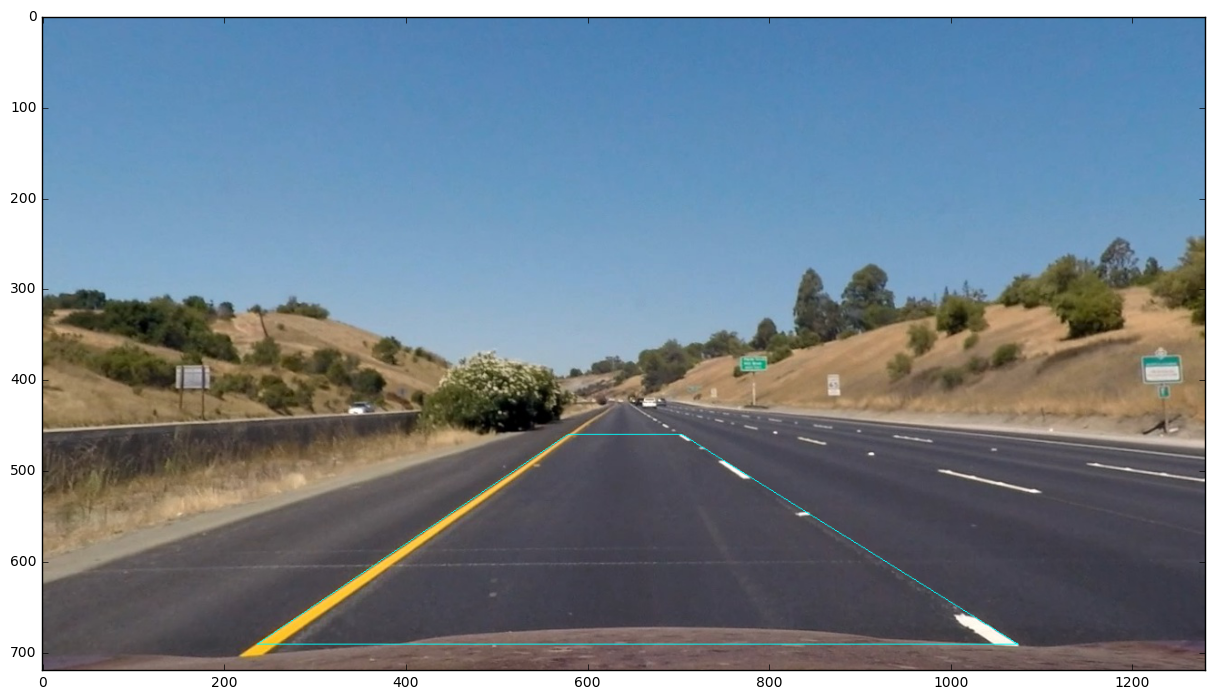

In [13]:
src_poly = [(236,691),(578,460),(703,460),(1073,691)]
im = plt.imread('output_images/undistorted_straight_lines1.jpg')
im = cv2.polylines(im, np.int32([src_poly]), isClosed=True, color=(0,255,255), thickness=1)
figure_big()
plt.imshow(im);


#### Goal: Use color transforms, gradients, etc., to create a thresholded binary image

In [14]:
import math


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        if line is not None:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def print_image(img,title=None):
    plt.figure()
    if title is not None:
        plt.title(title)
    plt.imshow(img,cmap='gray')

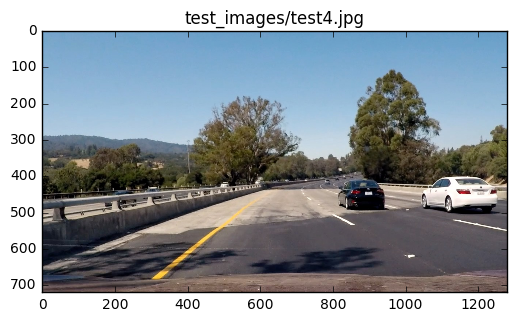

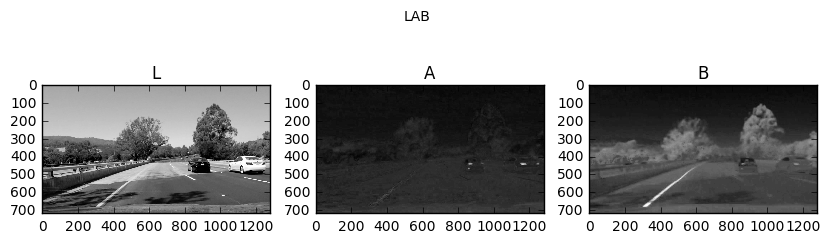

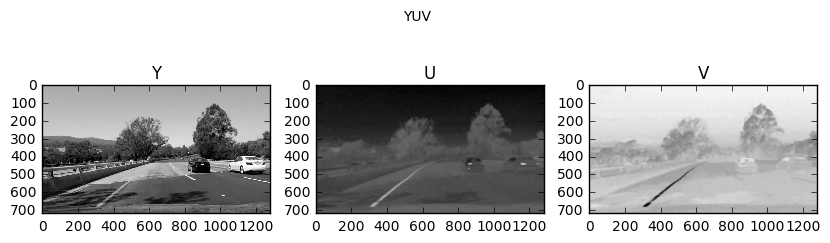

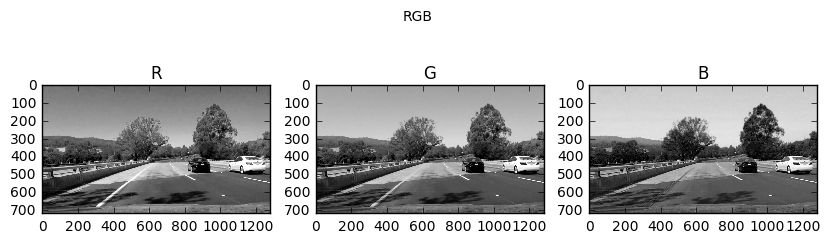

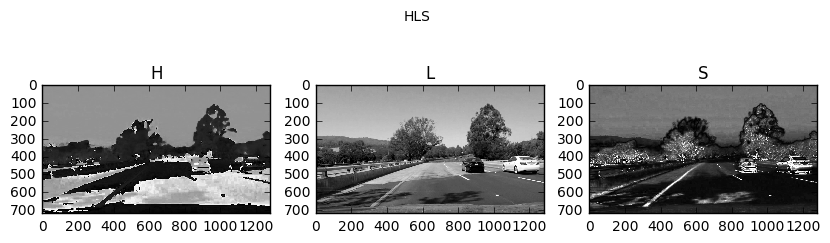

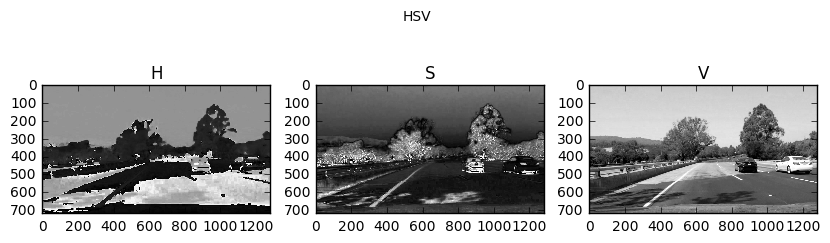

In [15]:
color_spaces = {"HLS": cv2.COLOR_RGB2HLS, "HSV": cv2.COLOR_RGB2HSV, "YUV":cv2.COLOR_RGB2YUV,"LAB":cv2.COLOR_RGB2LAB,"RGB":None}
for f in glob.glob('test_images/test4.jpg'):
    plt.figure()
    plt.title(f)
    im = plt.imread(f)
    plt.imshow(im)
    for space_name,space_conversion in color_spaces.items():
        fig = plt.figure()
        fig.suptitle(space_name)
        fig.set_size_inches(w=10,h=3)
        im2 = cv2.cvtColor(im,space_conversion) if space_conversion else im
        for i,c in enumerate(space_name):
            plt.subplot(1,3,i+1)
            plt.imshow(im2[:,:,i],cmap='gray')
            plt.title(c)

            

In [16]:
def hsl_gray_rgb(im):
    return cv2.cvtColor(cv2.cvtColor(im,cv2.COLOR_RGB2HLS)[:,:,2],cv2.COLOR_GRAY2RGB)

#### Goal: Apply a perspective transform to rectify binary image ("birds-eye view")

The Interstate Highway standards for the U.S. Interstate Highway System uses a 12-foot (3.7 m) standard for lane width
http://www.dot.ca.gov/trafficops/camutcd/docs/TMChapter6.pdf p.31

3.66m marking, 11m between, dot between

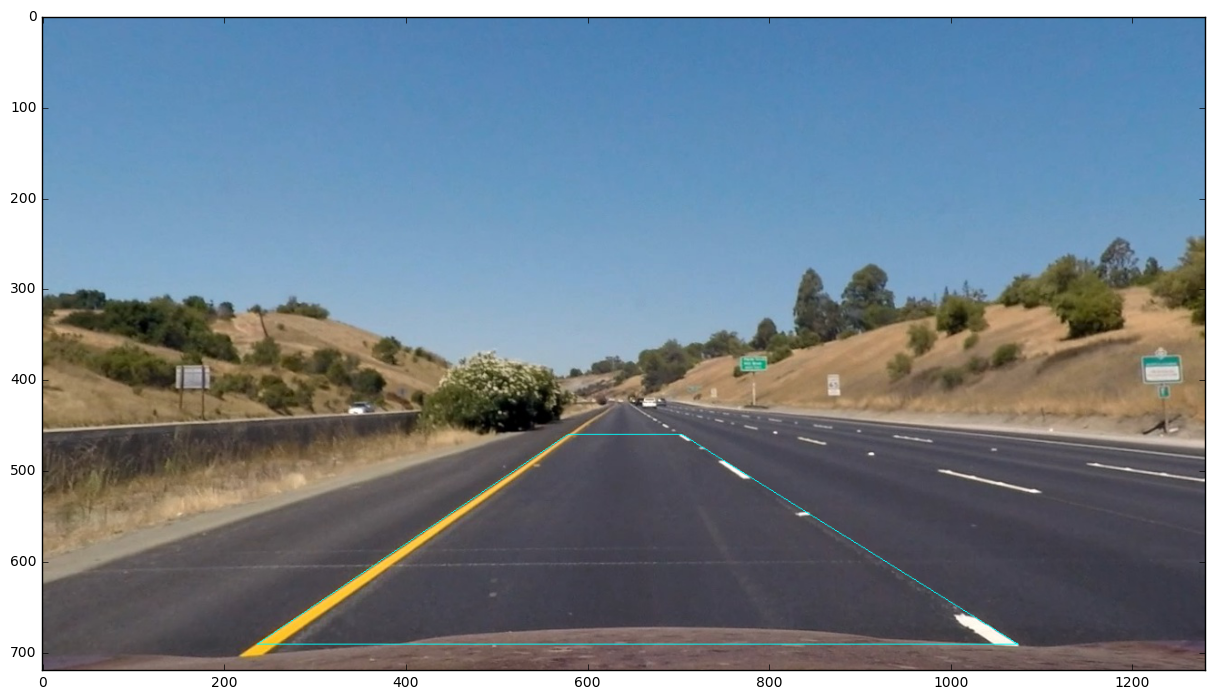

In [17]:
src_poly = [(236,691),(578,460),(703,460),(1073,691)]

im = plt.imread('output_images/undistorted_straight_lines1.jpg')
im = cv2.polylines(im, np.int32([src_poly]), isClosed=True, color=(0,255,255), thickness=1)
figure_big()
plt.imshow(im);

In [217]:
def birds_eye(im,flags=cv2.INTER_LINEAR,full_view = False, inverse=False):
    im_shape = (im.shape[1],im.shape[0]) # im_shape (1280, 720)
    # polygons to warp based on eyeballing lanes in Gimp
    dst = None
    src=np.array(src_poly,dtype=np.float32)
    if full_view:
        #src = np.array([(270,675),(615,434),(666,434),(1050,675)],dtype=np.float32)
        dst = np.array([(270,710),(270,-600),(1050,-600),(1050,710)],dtype=np.float32)
        dst[:,0] = 0.08805 * dst[:,0] + 540 # constant makes lane width to marker spacing ratio correct
    else:
        dst = np.array([(src[0][0],image_height),(src[0][0],0),(1100,0),(1100,image_height)],dtype=np.float32)
    if inverse:
        src,dst=dst,src
    transform = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(im,transform,im_shape,)

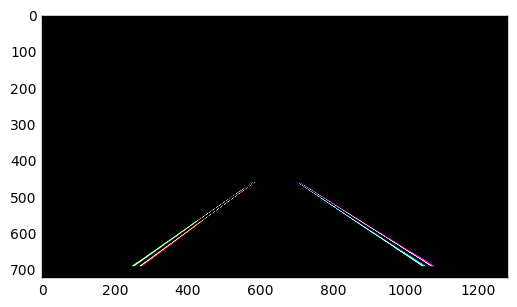

In [219]:
plt.imshow(birds_eye(im,inverse=True))

In [19]:
birds_eye_images = process_images(undistorted_test_images, birds_eye, prefix="birds_eye_");

In [20]:
display_images(glob.glob('output_images/birds_eye_*straight*'))

output_images/birds_eye_undistorted_straight_lines1.jpg
output_images/birds_eye_undistorted_straight_lines2.jpg


In [21]:
display_images(birds_eye_images,columns=4)

output_images/birds_eye_undistorted_test2.jpg,output_images/birds_eye_undistorted_test5.jpg,output_images/birds_eye_undistorted_test6.jpg,output_images/birds_eye_undistorted_test3.jpg
output_images/birds_eye_undistorted_test1.jpg,output_images/birds_eye_undistorted_straight_lines1.jpg,output_images/birds_eye_undistorted_test4.jpg,output_images/birds_eye_undistorted_straight_lines2.jpg


In [22]:
def find_lanes_on_birdseye(im):
    '''
    returns the x postion of where the lane line might be based on vertical
    histogram analysis
    '''
    mid_x=im.shape[1]//2
    mid_y = im.shape[0]//2
    h = np.sum(im[mid_y:,:,0],axis=0)
    x1 = np.argmax(h[0:mid_x])
    x2 = np.argmax(h[mid_x:])+mid_x
    return x1,x2

def draw_lanes_on_birdseye(im,x1,x2):
    for x in [x1,x2]:
        cv2.line(im,(x,0),(x,image_height),(0,0,255,100),thickness=3)
    s = "x1: {} x2: {} distance: {}".format(x1,x2,x2-x1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(im,s,(10,100), font, 2,(255,255,255),4,cv2.LINE_AA)
    return im

def find_and_draw_lanes_on_birdseye(im):
    x1,x2=find_lanes_on_birdseye(im)
    im = draw_lanes_on_birdseye(im,x1,x2)
    return im

In [23]:
line_guess_images = process_images(birds_eye_images, find_and_draw_lanes_on_birdseye, prefix='line_guess_')

In [24]:
display_images(line_guess_images,columns=2)

output_images/line_guess_birds_eye_undistorted_test2.jpg,output_images/line_guess_birds_eye_undistorted_test5.jpg
output_images/line_guess_birds_eye_undistorted_test6.jpg,output_images/line_guess_birds_eye_undistorted_test3.jpg
output_images/line_guess_birds_eye_undistorted_test1.jpg,output_images/line_guess_birds_eye_undistorted_straight_lines1.jpg
output_images/line_guess_birds_eye_undistorted_test4.jpg,output_images/line_guess_birds_eye_undistorted_straight_lines2.jpg


In [25]:
def lane_gray(im):
    '''
    returns a grayscale image where lane lines stand out the most, 
    currently using the R channel from RGB, returns as RGB for display convenience
    '''
    return cv2.cvtColor(im[:,:,0],cv2.COLOR_GRAY2RGB)

In [26]:
gray_birds_images = process_images(birds_eye_images,process_function=lane_gray,prefix='gray_birds_')

In [27]:
display_images(gray_birds_images,columns=2)

output_images/gray_birds_birds_eye_undistorted_test2.jpg,output_images/gray_birds_birds_eye_undistorted_test5.jpg
output_images/gray_birds_birds_eye_undistorted_test6.jpg,output_images/gray_birds_birds_eye_undistorted_test3.jpg
output_images/gray_birds_birds_eye_undistorted_test1.jpg,output_images/gray_birds_birds_eye_undistorted_straight_lines1.jpg
output_images/gray_birds_birds_eye_undistorted_test4.jpg,output_images/gray_birds_birds_eye_undistorted_straight_lines2.jpg


In [28]:
def detect_edges(im,ksize=21):
    return cv2.Sobel(im,cv2.CV_32F,dx=1,dy=0,ksize=ksize)

In [29]:
def threshold(gray):
    t = np.percentile(gray,99)
    _,rv= cv2.threshold(gray, t*.8, 255, cv2.THRESH_BINARY)
    
    return cv2.convertScaleAbs(rv)

In [30]:
t=plt.imread(gray_birds_images[0])

In [31]:
t=plt.imread(gray_birds_images[0])

In [32]:
def color_edges(im):
    '''
    takes a grayscale birdseye image as input
    
    returns an image with left edges in the red channel and right edges in the blue channel
    left/right split is blue channel (blue=right)
    '''
    e = detect_edges(im)
    right = threshold(e)
    left = threshold(-1.0*e)
    both = np.zeros_like(right)
    both[:,:,0] = left[:,:,0]
    both[:,:,1] = right[:,:,0]
    mid_x = both.shape[1]//2
    both[:,mid_x:,2]=both[:,mid_x:,0]+both[:,mid_x:,1] # add blue channel to right hand pixels
    return both


In [33]:
edges_images = process_images(gray_birds_images,process_function=color_edges,prefix='edges_')

In [34]:
display_images(edges_images,columns=2,title='left and right edges detected')

output_images/edges_gray_birds_birds_eye_undistorted_test2.jpg,output_images/edges_gray_birds_birds_eye_undistorted_test5.jpg
output_images/edges_gray_birds_birds_eye_undistorted_test6.jpg,output_images/edges_gray_birds_birds_eye_undistorted_test3.jpg
output_images/edges_gray_birds_birds_eye_undistorted_test1.jpg,output_images/edges_gray_birds_birds_eye_undistorted_straight_lines1.jpg
output_images/edges_gray_birds_birds_eye_undistorted_test4.jpg,output_images/edges_gray_birds_birds_eye_undistorted_straight_lines2.jpg


In [239]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

def fit_polynomial2(X,Y):
    '''
    returns coefficients,model of 2nd degree polynomial ransac fit
    '''
    X = np.reshape(np.array(X),(len(X),1))
    Y = np.reshape(np.array(Y),(len(Y),1))
    poly = PolynomialFeatures(degree=2)
    X_ = poly.fit_transform(X)
    try:
        model = linear_model.RANSACRegressor(linear_model.LinearRegression(fit_intercept=False),residual_threshold=5)
        model.fit(X_,Y)
    except ValueError:
        model = linear_model.RANSACRegressor(linear_model.LinearRegression(fit_intercept=False))
        model.fit(X_,Y)
    return (model.estimator_.coef_[0], model)



In [167]:
x = np.arange(10)
y=720+5*x+3.2*x*x
coef,model = fit_polynomial2(x,y)
print(coef)


[ 720.     5.     3.2]


In [168]:
def get_line_coefs_for_edges(im):
    '''
    returns four arrays of line coefficents (a,b,c) for the four lane line edges in im
    where x = a + b*y + c*y^2
    assums edges are colored green, red, cyan, magenta from left to right
    '''
    coef_list = []
    
    left_left = np.logical_and(im[:,:,1]>128,im[:,:,2]<128)
    left_right = np.logical_and(im[:,:,0]>128,im[:,:,2]<128)
    right_left = np.logical_and(im[:,:,0]>128,im[:,:,2]>128)
    right_right = np.logical_and(im[:,:,1]>128,im[:,:,2]>128)
    for im_edge in [left_left,left_right,right_left,right_right]:
        y,x = np.nonzero(im_edge)
        coefs,model=fit_polynomial2(y,x)
        coef_list.append(coefs)
    return coef_list

    

In [192]:
def draw_edge_lines(im,coefs_list):
    for coefs in coefs_list:
        a,b,c=coefs
        for y in range(image_height):
            x=int(a+b*y+c*y*y)
            cv2.drawMarker(im,(x,y),color=(255,255,255),markerSize=5)
    return im    

In [193]:
def find_and_draw_edge_lines(im):
    coefs_list = get_line_coefs_for_edges(im)
    return draw_edge_lines(im,coefs_list)


In [194]:
edge_draw_images = process_images(edges_images, process_function=find_and_draw_edge_lines, prefix='edge_drawn_')

In [195]:
display_images(edge_draw_images)

output_images/edge_drawn_edges_gray_birds_birds_eye_undistorted_test2.jpg
output_images/edge_drawn_edges_gray_birds_birds_eye_undistorted_test5.jpg
output_images/edge_drawn_edges_gray_birds_birds_eye_undistorted_test6.jpg
output_images/edge_drawn_edges_gray_birds_birds_eye_undistorted_test3.jpg
output_images/edge_drawn_edges_gray_birds_birds_eye_undistorted_test1.jpg
output_images/edge_drawn_edges_gray_birds_birds_eye_undistorted_straight_lines1.jpg
output_images/edge_drawn_edges_gray_birds_birds_eye_undistorted_test4.jpg
output_images/edge_drawn_edges_gray_birds_birds_eye_undistorted_straight_lines2.jpg


In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [232]:
def process_one_image(im):
    im_undistorted = camera.undistort(im)
    im_birds_eye = birds_eye(im_undistorted)
    im_gray = lane_gray(im_birds_eye)
    im_color_edges = color_edges(im_gray)
    coeffs_list = get_line_coefs_for_edges(im_color_edges)
    draw_edge_lines(im_color_edges,coeffs_list)
    im_undistorted_edges = birds_eye(im_color_edges, inverse=True)
    im_final = cv2.addWeighted(im_undistorted,1.0,im_undistorted_edges,0.5,0)
    
    return im_final
    

In [241]:
processed_images = process_images(test_images,process_function=process_one_image, prefix="processed_")
display_images(processed_images,width=2)

output_images/processed_test2.jpg
output_images/processed_test5.jpg
output_images/processed_test6.jpg
output_images/processed_test3.jpg
output_images/processed_test1.jpg
output_images/processed_straight_lines1.jpg
output_images/processed_test4.jpg
output_images/processed_straight_lines2.jpg


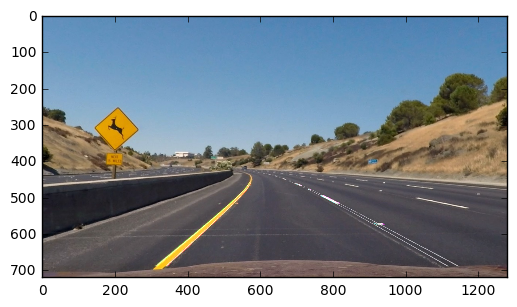

In [233]:

plt.imshow(process_one_image(plt.imread(test_images[0])))

In [ ]:
def grey_birds_eye_rgb(im):
    return birds_eye(lane_gray_rgb(im))

process_videos(undistorted_videos, grey_birds_eye_rgb,'grey_birds_eye',side_by_side=True,plot=True)   

#### Goal: Detect lane pixels and fit to find the lane boundary

#### Goal: Determine the curvature of the lane and vehicle position with respect to center.

#### Goal: Warp the detected lane boundaries back onto the original image.

#### Goal: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

# Video processing

In [198]:
def video_tag(path,width=300,height=240,title=""):
    return """
    <div style="float:left;padding-left:5px">
    <p>{3}</p>
    <video width="{1}" height="{2}" controls>
      <source src="{0}">
    </video>
    </div>
    """.format(path,width,height,title)

In [199]:
class SideBySideProcessor:
    def __init__ (self, process_callback):
        self.process_callback = process_callback
    def process_image(self, im):
        im_processed = self.process_callback(im)
        im_side_by_side = np.concatenate((im, im_processed), axis=1)
        return im_side_by_side

In [200]:
def process_videos(
    input_videos, 
    process_function, 
    prefix, output_folder = 'output_videos', 
    overwrite=False,
    plot=False,
    side_by_side=False
):
    output_paths = []
    if side_by_side:
        p = SideBySideProcessor(process_function)
        process_function = p.process_image

    
    for input_path in input_videos:
        output_path = output_folder+"/"+prefix+'_'+os.path.basename(input_path)
        output_paths.append(output_path)
        if overwrite or not os.path.exists(output_path) or os.path.getmtime(output_path) < os.path.getmtime(input_path):
            clip1 = VideoFileClip(input_path)
            white_clip = clip1.fl_image(process_function) #NOTE: this function expects color images!!
            %time white_clip.write_videofile(output_path, audio=False)
        
        if plot:
            #html =  video_tag(input_path,title=input_path)
            html = video_tag(output_path,title=output_path)
            display.display(display.HTML(html))
    return output_paths
    

In [202]:
process_videos(input_videos[:1],process_function = process_one_image, prefix='processed_')

[MoviePy] >>>> Building video output_videos/processed__project_video.mp4
[MoviePy] Writing video output_videos/processed__project_video.mp4


100%|█████████▉| 1260/1261 [07:17<00:00,  3.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/processed__project_video.mp4 

CPU times: user 56min 2s, sys: 19.1 s, total: 56min 21s
Wall time: 7min 17s


['output_videos/processed__project_video.mp4']

In [ ]:
def delete_files(file_list):
    for f in file_list:
        os.remove(f)

In [ ]:
undistorted_videos = process_videos(input_videos, camera.undistort, prefix='undistorted',plot=True)
button = ipywidgets.Button(description='Delete Output')
button.on_click(lambda b: delete_files(undistorted_videos))
display.display(button)


In [ ]:
process_videos(undistorted_videos, birds_eye,'birds_eye',side_by_side=True,plot=True)  

In [ ]:
process_videos(input_videos,hsl_gray_rgb,prefix='hsl_gray',plot=True,side_by_side=True)

In [ ]:
process_videos(input_videos,lane_gray_rgb,prefix='lane_gray',side_by_side=True ,plot=True)